In [3]:
!pip install rasterio geopandas

In [4]:
import rasterio
from rasterio import mask
from rasterio.plot import show,show_hist

import matplotlib.pyplot as plt
import plotly.express as px

import geopandas as gpd
import numpy as np
import json

import shapely
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union
import shapely.speedups

shapely.speedups.enable()

In [5]:
# SELECT runtime { local | colab }
runtime = 'colab'

In [6]:
# Assign Runtime based on user input

if runtime == 'local':
    os_path_selected = ''

if runtime == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    os_path_selected = '/content/drive/My Drive/World Bank Projects/Blog_Data_Analytics/Population Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and Exploring Population Data in Raster Format from WorldPop

In [7]:
#WorldPop Unconstrained Global Mosaic 2020 - Estimated total number of people per grid-cell. 
worldpop_raster = rasterio.open(os_path_selected+'wp_ppp_2020_1km_Aggregated.tif')

In [8]:
#Calculating Total World Population
worldpop_raster_tot = worldpop_raster.read(1)
worldpop_raster_tot[worldpop_raster_tot<0] = None

In [ ]:
plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10(worldpop_raster_tot+1),)
bar = plt.colorbar(fraction=0.03)

In [ ]:
worldpop_raster_nonzero = worldpop_raster_tot[worldpop_raster_tot>0]
population_worldpop = worldpop_raster_nonzero[worldpop_raster_nonzero > 0].sum()
print(round(population_worldpop/1000000000,2),'billion')

In [ ]:
#GADM, the Database of Global Administrative Areas
global_administrative_boundaries = gpd.read_file(os_path_selected+'gadm36_shp/gadm36.shp')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
global_administrative_boundaries.plot(ax=ax)
plt.show()

In [ ]:
global_administrative_boundaries['NAME_0'].nunique()

256

In [ ]:
global_administrative_boundaries['NAME_0'].unique()

array(['Afghanistan', 'Akrotiri and Dhekelia', 'Åland', 'Albania',
       'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Bouvet Island', 'Brazil',
       'British Indian Ocean Territory', 'British Virgin Islands',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Caspian Sea',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Christmas Island', 'Clipperton Island', 'Cocos Islands',
       'Colombia', 'Comoros', 'Cook Islands', 'Costa Rica',
       "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus',
       'Czech Republic', 'Democ

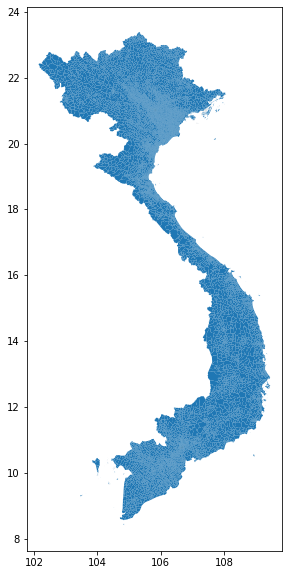

In [ ]:
vietnam_administrative_boundaries = global_administrative_boundaries[global_administrative_boundaries['NAME_0']=='Vietnam']
fig, ax = plt.subplots(figsize = (10,10))
vietnam_administrative_boundaries.plot(ax=ax)
plt.show()

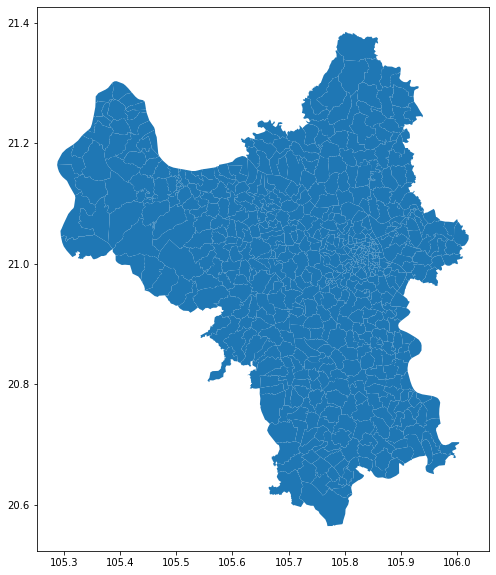

In [ ]:
hanoi_administrative_boundaries = vietnam_administrative_boundaries[vietnam_administrative_boundaries['NAME_1']=='Hà Nội']
fig, ax = plt.subplots(figsize = (10,10))
hanoi_administrative_boundaries.plot(ax=ax)
plt.show()

In [ ]:
def get_population_count(vector_polygon,raster_layer):
    gtraster, bound = rasterio.mask.mask(raster_layer, [vector_polygon], crop=True)
    pop_estimate = gtraster[0][gtraster[0]>0].sum()
    return (pop_estimate.round())

In [ ]:
%%time

vietnam_administrative_boundaries['population_count'] = vietnam_administrative_boundaries['geometry'].apply(get_population_count,raster_layer=worldpop_raster)


In [ ]:
adm_level_0 = vietnam_administrative_boundaries.groupby(['NAME_1']).agg({'geometry':lambda x: list(x),'population_count':'sum'}).reset_index()

def concat_polygon(geometry_list):
    polygons = geometry_list
    boundary = gpd.GeoSeries(cascaded_union(polygons))
    return boundary.to_json()
adm_level_0['geometry'] = adm_level_0['geometry'].apply(concat_polygon)


In [ ]:
# Instantiate list of features
dept_geo = []

# Get data from dataset (using json.loads to transform string into dict for geoshape column)
cd_depts = adm_level_0['NAME_1'].tolist()
shapes = adm_level_0['geometry'].values

# Iterate over lines
for x in range(0,len(adm_level_0['geometry'].values),1):
    shape = json.loads(adm_level_0['geometry'].values[x])['features'][0]['geometry']
    # Mapping information from data to GeoJSON file
    dept_geo.append({
        'type': 'Feature',
        'geometry': shape,
        'id':cd_depts[x]
    })

# Encapsulate dept_geo in a real GeoJSON formatted file
dept_geo_ok = {'type': 'FeatureCollection', 'features': dept_geo}

In [1]:
adm_level_0 = adm_level_0[['NAME_1','population_count']]

NameError: ignored

In [2]:
fig = px.choropleth(adm_level_0, geojson=dept_geo_ok, locations='NAME_0', color='population_count',
                           color_continuous_scale="Viridis",
                           range_color=(adm_level_0['population_count'].min(), adm_level_0['population_count'].max()),
                           labels={'population_count':'Estimated Population Count'}
                          )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

NameError: ignored